Compare Adam and SGD optimizers on CIFAR-10. You should try the specific CNN architecture the authors mention in the Adam paper (https://arxiv.org/pdf/1412.6980.pdf) and a small ResNet. Is the pattern of results similar with the two architectures?

In [2]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import os
from PIL import Image
import ast
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy
import pickle

os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# Transforms for training and testing. We use the CIFAR 10 means
# and stdevs from https://github.com/facebookarchive/fb.resnet.torch/issues/180

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.262)),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.262)),
])

# Load the CIFAR-10 dataset

train_dataset = torchvision.datasets.CIFAR10(root='./data', transform=train_transforms, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', transform=test_transforms, train=False, download=True)

# Category labels

cat_labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

# Create data loaders from train/test datasets

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, num_workers=4)

dataloaders = {'train': train_dataloader, 'val': test_dataloader}

/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


Files already downloaded and verified
Files already downloaded and verified


In [3]:
def top1_error(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels.data)
    return 1 - correct / len(labels)
def train_model(model, dataloaders, criterion, optimizer, num_epochs, weights_name='weight_save', is_inception=False):
    since = time.time()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    train_errors = []
    val_errors = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_error = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_error += top1_error(outputs, labels) * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            epoch_error = running_error / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                train_errors.append(epoch_error)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                val_errors.append(epoch_error)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, weights_name)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, train_errors, val_loss_history, val_acc_history, val_errors




## 1. CNN Model by manual

In [17]:
class CNN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=5, padding=2,stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64, kernel_size=5, padding=2,stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=5, padding=2,stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        
        self.fc1 = nn.Linear(3*3*128,192)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(192,10)
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [20]:
from tqdm import tqdm

# Load models

model1 = CNN_Model()

# Training loop

device = 'cuda:2'
num_epochs = 25
criterion1 = torch.nn.CrossEntropyLoss()
params_to_update1 = model1.parameters()
optimizer1 = torch.optim.SGD(params_to_update1, lr=0.001, momentum=0.9, weight_decay=0.0005)
#optimizer1 = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

_, train_loss_history1, train_acc_history1, train_errors1, val_loss_history1, val_acc_history1, val_errors1 = train_model(model1, dataloaders, criterion1, optimizer1, num_epochs, weights_name='weight_save', is_inception=False)

Epoch 1/25
----------
train Loss: 1.5153 Acc: 0.4624
val Loss: 1.2000 Acc: 0.5690

Epoch 2/25
----------
train Loss: 1.0537 Acc: 0.6298
val Loss: 1.0618 Acc: 0.6184

Epoch 3/25
----------
train Loss: 0.8978 Acc: 0.6854
val Loss: 1.0709 Acc: 0.6285

Epoch 4/25
----------
train Loss: 0.8064 Acc: 0.7199
val Loss: 0.8347 Acc: 0.7135

Epoch 5/25
----------
train Loss: 0.7318 Acc: 0.7467
val Loss: 0.9147 Acc: 0.6984

Epoch 6/25
----------
train Loss: 0.6816 Acc: 0.7672
val Loss: 0.7982 Acc: 0.7301

Epoch 7/25
----------
train Loss: 0.6386 Acc: 0.7796
val Loss: 0.7560 Acc: 0.7446

Epoch 8/25
----------
train Loss: 0.5987 Acc: 0.7932
val Loss: 0.8333 Acc: 0.7191

Epoch 9/25
----------
train Loss: 0.5660 Acc: 0.8046
val Loss: 0.7049 Acc: 0.7623

Epoch 10/25
----------
train Loss: 0.5362 Acc: 0.8163
val Loss: 0.6713 Acc: 0.7699

Epoch 11/25
----------
train Loss: 0.5087 Acc: 0.8248
val Loss: 0.7435 Acc: 0.7501

Epoch 12/25
----------
train Loss: 0.4814 Acc: 0.8340
val Loss: 0.6382 Acc: 0.7888

E

<function matplotlib.pyplot.show(close=None, block=None)>

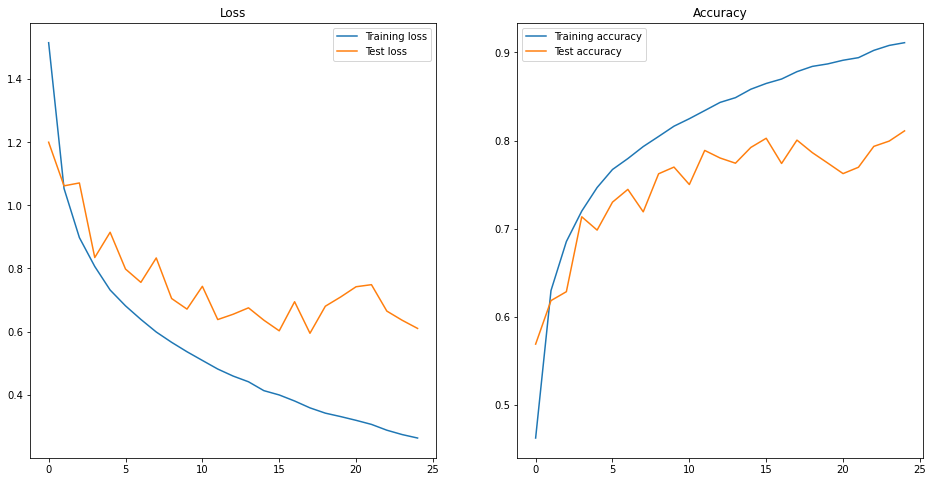

In [21]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history1, label='Training loss')
plt.plot(val_loss_history1, label='Test loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in train_acc_history1], label='Training accuracy')
plt.plot([x.cpu() for x in val_acc_history1], label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show

In [22]:
model2 = CNN_Model()
params_to_update2 = model2.parameters()
criterion2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)
_, train_loss_history2, train_acc_history2, train_errors2, val_loss_history2, val_acc_history2, val_errors2 = train_model(model2, dataloaders, criterion2, optimizer2, num_epochs, weights_name='weight_save', is_inception=False)

Epoch 1/25
----------
train Loss: 1.3416 Acc: 0.5228
val Loss: 1.0659 Acc: 0.6255

Epoch 2/25
----------
train Loss: 0.9803 Acc: 0.6571
val Loss: 0.9897 Acc: 0.6504

Epoch 3/25
----------
train Loss: 0.8570 Acc: 0.7016
val Loss: 0.9697 Acc: 0.6608

Epoch 4/25
----------
train Loss: 0.7677 Acc: 0.7355
val Loss: 0.8285 Acc: 0.7135

Epoch 5/25
----------
train Loss: 0.7111 Acc: 0.7555
val Loss: 0.7663 Acc: 0.7358

Epoch 6/25
----------
train Loss: 0.6598 Acc: 0.7742
val Loss: 0.7430 Acc: 0.7444

Epoch 7/25
----------
train Loss: 0.6156 Acc: 0.7896
val Loss: 0.7719 Acc: 0.7398

Epoch 8/25
----------
train Loss: 0.5806 Acc: 0.8010
val Loss: 0.7542 Acc: 0.7461

Epoch 9/25
----------
train Loss: 0.5462 Acc: 0.8129
val Loss: 0.8834 Acc: 0.7051

Epoch 10/25
----------
train Loss: 0.5206 Acc: 0.8213
val Loss: 0.7837 Acc: 0.7308

Epoch 11/25
----------
train Loss: 0.4939 Acc: 0.8331
val Loss: 0.6801 Acc: 0.7680

Epoch 12/25
----------
train Loss: 0.4691 Acc: 0.8394
val Loss: 0.7119 Acc: 0.7503

E

<function matplotlib.pyplot.show(close=None, block=None)>

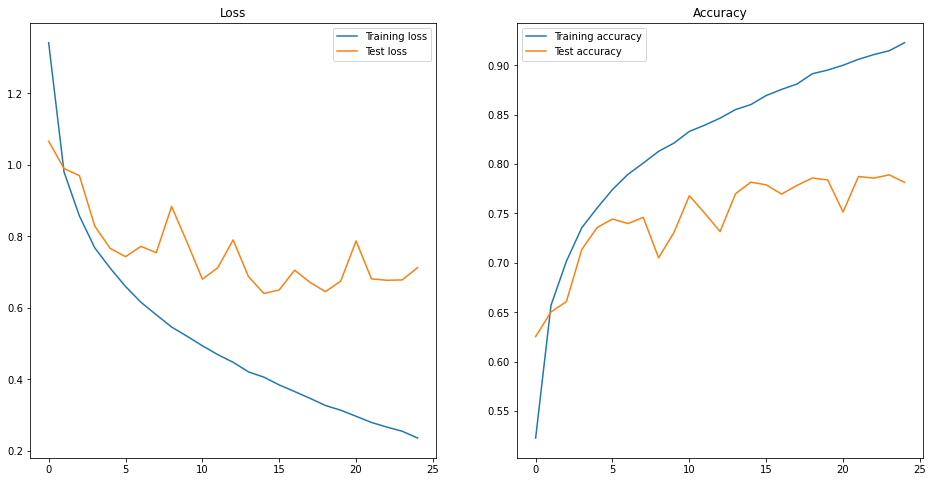

In [23]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history2, label='Training loss')
plt.plot(val_loss_history2, label='Test loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in train_acc_history2], label='Training accuracy')
plt.plot([x.cpu() for x in val_acc_history2], label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show

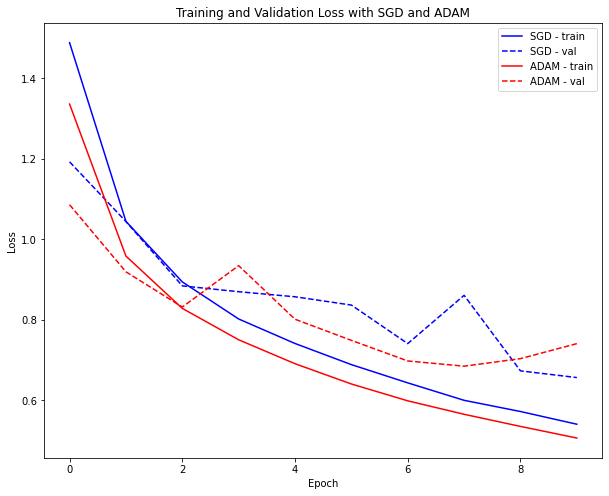

In [48]:
epochs = range(num_epochs)
fig = plt.figure(figsize=(10, 8))
plt.plot(epochs, train_loss_history1, 'b-', label='SGD - train')
plt.plot(epochs, val_loss_history1, 'b--', label='SGD - val')
plt.plot(epochs, train_loss_history2, 'r-', label='ADAM - train')
plt.plot(epochs, val_loss_history2, 'r--', label='ADAM - val')
plt.title('Training and Validation Loss with SGD and ADAM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2. Small ResNet

In [4]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()

        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

def SmallResNet(num_classes=10):
    return ResNet(ResBlock, [2, 2, 2], num_classes)


In [13]:
model3 = SmallResNet()

# Training loop
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
                     
num_epochs = 25
criterion3 = torch.nn.CrossEntropyLoss()
params_to_update3 = model3.parameters()
optimizer3 = torch.optim.SGD(params_to_update3, lr=0.001, momentum=0.9, weight_decay=0.0005)
#optimizer1 = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

_, train_loss_history3, train_acc_history3, train_errors3, val_loss_history3, val_acc_history3, val_errors3 = train_model(model3, dataloaders, criterion3, optimizer3, num_epochs, weights_name='weight_save', is_inception=False)

Epoch 1/25
----------
train Loss: 1.8989 Acc: 0.2934
val Loss: 1.6701 Acc: 0.3646

Epoch 2/25
----------
train Loss: 1.5637 Acc: 0.4109
val Loss: 1.4756 Acc: 0.4545

Epoch 3/25
----------
train Loss: 1.4028 Acc: 0.4800
val Loss: 1.3475 Acc: 0.5000

Epoch 4/25
----------
train Loss: 1.2782 Acc: 0.5320
val Loss: 1.2456 Acc: 0.5462

Epoch 5/25
----------
train Loss: 1.1777 Acc: 0.5732
val Loss: 1.1851 Acc: 0.5683

Epoch 6/25
----------
train Loss: 1.0961 Acc: 0.6051
val Loss: 1.1084 Acc: 0.6007

Epoch 7/25
----------
train Loss: 1.0343 Acc: 0.6281
val Loss: 1.0476 Acc: 0.6309

Epoch 8/25
----------
train Loss: 0.9789 Acc: 0.6490
val Loss: 1.0367 Acc: 0.6283

Epoch 9/25
----------
train Loss: 0.9312 Acc: 0.6660
val Loss: 0.9765 Acc: 0.6547

Epoch 10/25
----------
train Loss: 0.8887 Acc: 0.6828
val Loss: 0.9231 Acc: 0.6784

Epoch 11/25
----------
train Loss: 0.8525 Acc: 0.6962
val Loss: 0.9110 Acc: 0.6794

Epoch 12/25
----------
train Loss: 0.8136 Acc: 0.7127
val Loss: 0.8548 Acc: 0.6973

E

<function matplotlib.pyplot.show(close=None, block=None)>

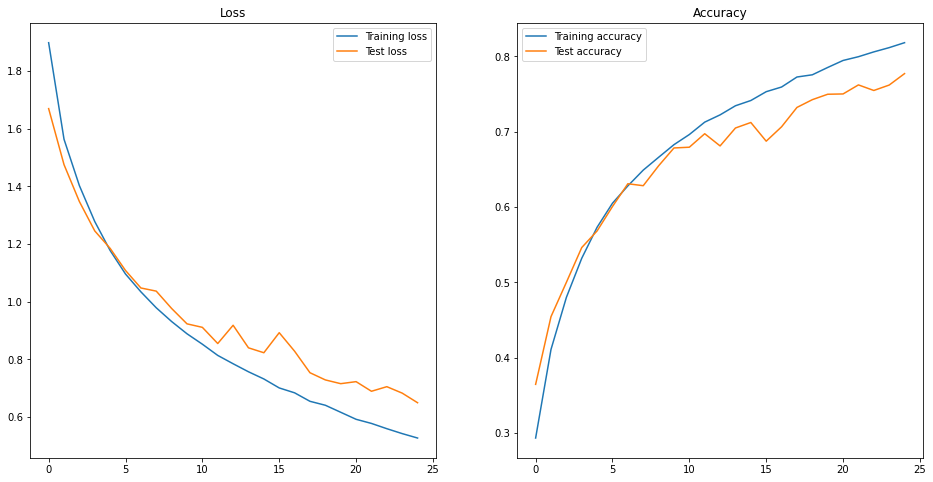

In [27]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history3, label='Training loss')
plt.plot(val_loss_history3, label='Test loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in train_acc_history3], label='Training accuracy')
plt.plot([x.cpu() for x in val_acc_history3], label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show

In [14]:
model4 = SmallResNet()
params_to_update4 = model4.parameters()
criterion4 = torch.nn.CrossEntropyLoss()
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.0001)
_, train_loss_history4, train_acc_history4, train_errors4, val_loss_history4, val_acc_history4, val_errors4 = train_model(model4, dataloaders, criterion4, optimizer4, num_epochs, weights_name='weight_save', is_inception=False)

Epoch 1/25
----------
train Loss: 1.7322 Acc: 0.3699
val Loss: 1.5280 Acc: 0.4440

Epoch 2/25
----------
train Loss: 1.3527 Acc: 0.5150
val Loss: 1.2737 Acc: 0.5402

Epoch 3/25
----------
train Loss: 1.2009 Acc: 0.5706
val Loss: 1.1478 Acc: 0.5823

Epoch 4/25
----------
train Loss: 1.0951 Acc: 0.6079
val Loss: 1.0688 Acc: 0.6170

Epoch 5/25
----------
train Loss: 1.0141 Acc: 0.6393
val Loss: 1.0062 Acc: 0.6389

Epoch 6/25
----------
train Loss: 0.9575 Acc: 0.6598
val Loss: 1.0079 Acc: 0.6370

Epoch 7/25
----------
train Loss: 0.9053 Acc: 0.6767
val Loss: 0.9804 Acc: 0.6493

Epoch 8/25
----------
train Loss: 0.8652 Acc: 0.6929
val Loss: 0.8990 Acc: 0.6794

Epoch 9/25
----------
train Loss: 0.8262 Acc: 0.7091
val Loss: 0.9041 Acc: 0.6807

Epoch 10/25
----------
train Loss: 0.7924 Acc: 0.7213
val Loss: 0.8481 Acc: 0.6963

Epoch 11/25
----------
train Loss: 0.7582 Acc: 0.7342
val Loss: 0.8290 Acc: 0.6986

Epoch 12/25
----------
train Loss: 0.7305 Acc: 0.7458
val Loss: 0.8095 Acc: 0.7098

E

<function matplotlib.pyplot.show(close=None, block=None)>

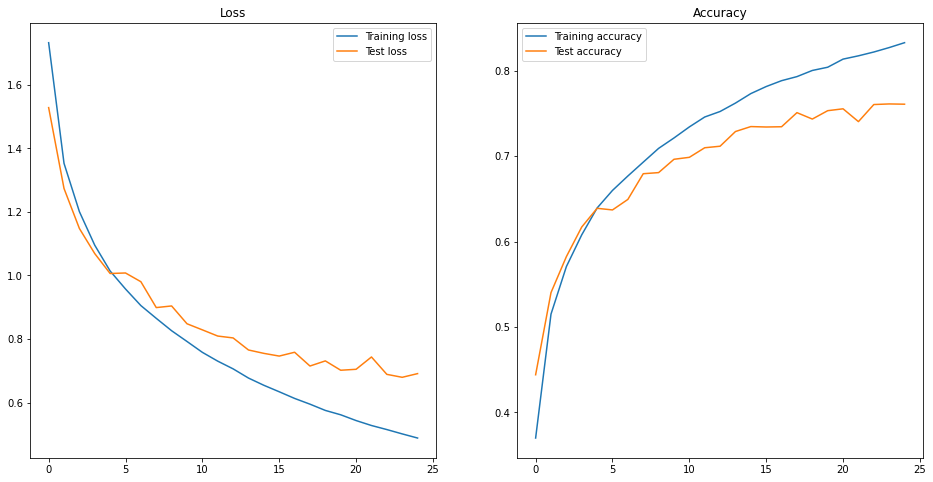

In [28]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history4, label='Training loss')
plt.plot(val_loss_history4, label='Test loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in train_acc_history4], label='Training accuracy')
plt.plot([x.cpu() for x in val_acc_history4], label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show

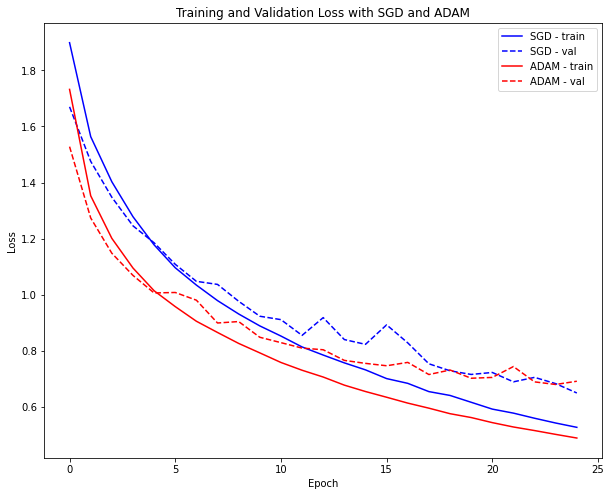

In [15]:
epochs = range(num_epochs)
fig = plt.figure(figsize=(10, 8))
plt.plot(epochs, train_loss_history3, 'b-', label='SGD - train')
plt.plot(epochs, val_loss_history3, 'b--', label='SGD - val')
plt.plot(epochs, train_loss_history4, 'r-', label='ADAM - train')
plt.plot(epochs, val_loss_history4, 'r--', label='ADAM - val')
plt.title('Training and Validation Loss with SGD and ADAM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

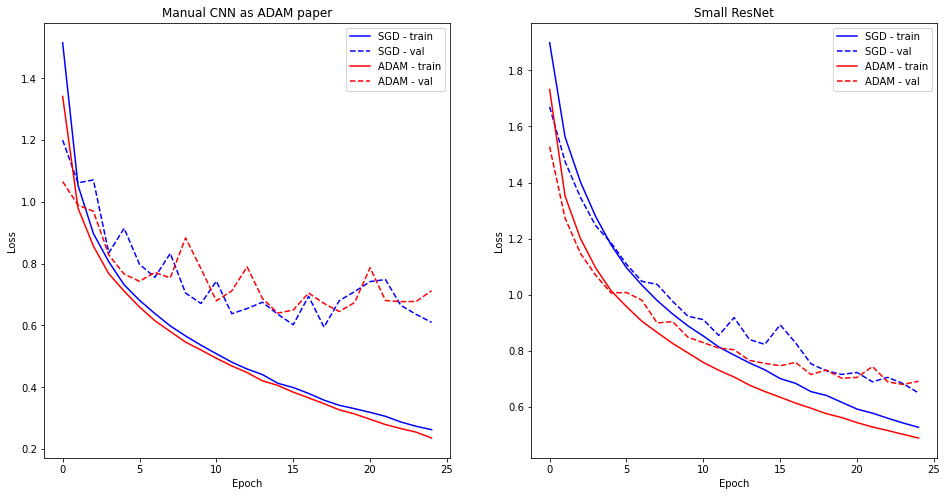

In [26]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history1, 'b-', label='SGD - train')
plt.plot(epochs, val_loss_history1, 'b--', label='SGD - val')
plt.plot(epochs, train_loss_history2, 'r-', label='ADAM - train')
plt.plot(epochs, val_loss_history2, 'r--', label='ADAM - val')
plt.title('Manual CNN as ADAM paper')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history3, 'b-', label='SGD - train')
plt.plot(epochs, val_loss_history3, 'b--', label='SGD - val')
plt.plot(epochs, train_loss_history4, 'r-', label='ADAM - train')
plt.plot(epochs, val_loss_history4, 'r--', label='ADAM - val')
plt.title('Small ResNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()